In [1]:
from myutils import Datasets as ds
from myutils import Helpers as h
from myutils import Complexity_Measures as cm
import numpy as np
from matplotlib import pyplot as plt
import itertools
import os

#Magic Command, so changes in myutils module are reloaded
%load_ext autoreload
%autoreload 1
%aimport myutils

Concat=True, combines the training and test dataset.

Here to have more data to evalutate the complexity measures (no split is needed in this step, so why not use all of the data)

In [ ]:
data = ds.get_all_data(concat=True)

In [ ]:
for dataset in data:
    data[dataset]["x_pca"] = h.PCA(data[dataset]["x"],n_components=4)
    data[dataset]["x_pca"] = h.normalize(data[dataset]["x_pca"])

Folgende Formel aus Paper nach implementiert:  
![](images/Fischer_F1_formula.png)

In [ ]:
for dataset in data:
    fischer = cm.fischer_discriminat_ratio(data[dataset]["x_pca"], data[dataset]["y"])
    data[dataset]["fdr"] = fischer

Eine Interessante Beobachtung ist, dass im Dataset Six and Nines der linke obere Pixel einen hohen Wert bekommt. Das ist ganeu der Pixel der in der manuellen Klassifikation als Unterscheidungsmerkmal benutzt wird.

In [ ]:
i=0
# plot fdr in grid
fig, ax = plt.subplots(1,5,figsize=(15,10))
for dataset in data:
    ax[i].imshow(np.round(data[dataset]["fdr"],5).reshape(2,2),cmap="Blues")
    for j in range(2):
        for k in range(2):
            ax[i].annotate("{:.4f}".format(data[dataset]["fdr"][j*2+k]),xy=(k-0.35,j))
    ax[i].set_title(dataset)
    i+=1

![](images/MaxFischer.png)

In [ ]:
for dataset in data:
    print(dataset, 1 / (1 + np.amax(data[dataset]["fdr"])))

In [2]:
all_numbers = ds.get_all_data(concat=True)["ALL_NUMBERS"]

ALL_NUMBERS
SIX_AND_NINES
ONLY_SIXES
RANDOM
SAMEPICTURE


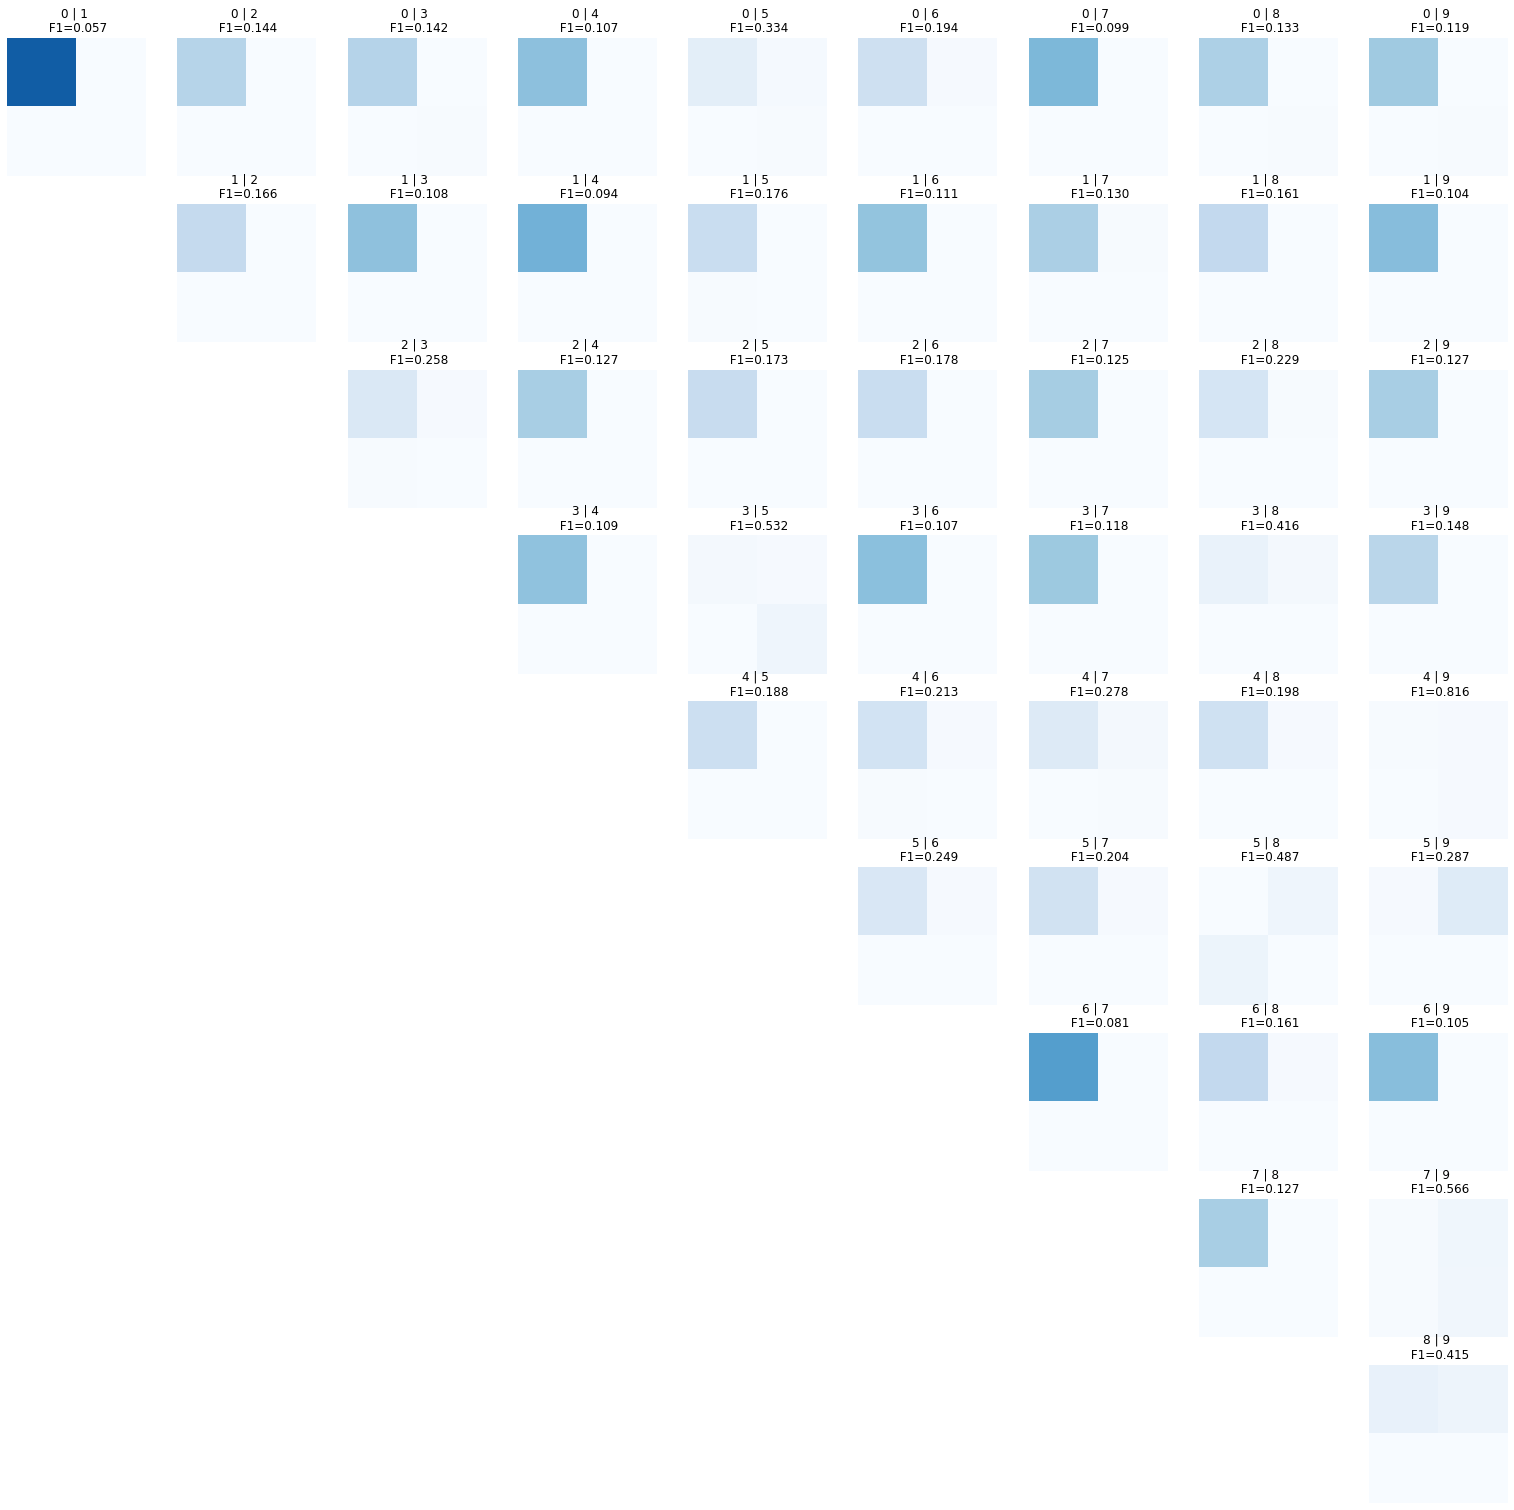

In [15]:
if os.path.exists("results/fischer.json"):
    os.remove("results/fischer.json")


fig,ax = plt.subplots(10,10,figsize=(30,30))

for subset in itertools.combinations([i for i in range(10)],2):
   
    x = all_numbers["x"][(all_numbers["y"] == subset[0]) | (all_numbers["y"] == subset[1])]
    y = all_numbers["y"][(all_numbers["y"] == subset[0]) | (all_numbers["y"] == subset[1])]

    x_pca = h.PCA(x,n_components=4)
    x_pca = h.normalize(x_pca)
    
    fischer = cm.fischer_discriminat_ratio(x_pca, y)
    
    ax[subset[0],subset[1]].axis("off")
    ax[subset[0],subset[1]].set_title("{} | {} \n F1={:.3f}".format(subset[0],subset[1],(1/(1+np.amax(fischer)))))
    plot = ax[subset[0],subset[1]].imshow(np.round(fischer,5).reshape(2,2),cmap="Blues",vmin=0,vmax=20)


    h.log_results(filename="results/fischer.json",result={
        str(subset):1/(1+np.amax(fischer))
    }) 

# hide combinations with empty plots
for i in range(10):
    for j in range(i+1):
        fig.delaxes(ax[i][j])

plt.show()

In [3]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, losses

In [7]:
latent_dim = 4 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded



Epoch 1/10
  30/2188 [..............................] - ETA: 7s - loss: 0.2113

2021-12-02 14:36:36.085680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2188/2188 [==============================] - 8s 3ms/step - loss: 0.0600
Epoch 2/10
2188/2188 [==============================] - 7s 3ms/step - loss: 0.0488
Epoch 3/10
2188/2188 [==============================] - 7s 3ms/step - loss: 0.0475
Epoch 4/10
2188/2188 [==============================] - 7s 3ms/step - loss: 0.0470
Epoch 5/10
2188/2188 [==============================] - 7s 3ms/step - loss: 0.0467
Epoch 6/10
2188/2188 [==============================] - 7s 3ms/step - loss: 0.0466
Epoch 7/10
2188/2188 [==============================] - 7s 3ms/step - loss: 0.0465
Epoch 8/10
2188/2188 [==============================] - 7s 3ms/step - loss: 0.0464
Epoch 9/10
2188/2188 [==============================] - 7s 3ms/step - loss: 0.0463
Epoch 10/10
2188/2188 [==============================] - 7s 3ms/step - loss: 0.0463


In [9]:
all_numbers["x_auto"] = autoencoder.encoder(all_numbers["x"]/255)

In [11]:
all_numbers["x_auto"] = all_numbers["x_auto"].numpy()

In [12]:
all_numbers["x_auto"].shape

(70000, 4)

Epoch 1/2
 30/462 [>.............................] - ETA: 1s - loss: 0.2193

2021-12-02 14:52:36.759654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


462/462 [==============================] - 2s 3ms/step - loss: 0.0744
Epoch 2/2
462/462 [==============================] - 1s 3ms/step - loss: 0.0386
Epoch 1/2
 48/435 [==>...........................] - ETA: 1s - loss: 0.1878

2021-12-02 14:52:40.050736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


435/435 [==============================] - 2s 4ms/step - loss: 0.0843
Epoch 2/2
435/435 [==============================] - 1s 3ms/step - loss: 0.0550
Epoch 1/2
 47/439 [==>...........................] - ETA: 1s - loss: 0.1987

2021-12-02 14:52:43.343756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


439/439 [==============================] - 2s 3ms/step - loss: 0.0809
Epoch 2/2
439/439 [==============================] - 1s 3ms/step - loss: 0.0516
Epoch 1/2
 41/429 [=>............................] - ETA: 1s - loss: 0.1988

2021-12-02 14:52:46.539207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - 2s 4ms/step - loss: 0.0801
Epoch 2/2
429/429 [==============================] - 1s 3ms/step - loss: 0.0504
Epoch 1/2
 62/413 [===>..........................] - ETA: 0s - loss: 0.1806

2021-12-02 14:52:49.813264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


413/413 [==============================] - 1s 2ms/step - loss: 0.0855
Epoch 2/2
413/413 [==============================] - 1s 2ms/step - loss: 0.0525
Epoch 1/2
 45/431 [==>...........................] - ETA: 1s - loss: 0.1974

2021-12-02 14:52:52.124510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


431/431 [==============================] - 2s 3ms/step - loss: 0.0787
Epoch 2/2
431/431 [==============================] - 1s 3ms/step - loss: 0.0470
Epoch 1/2
 42/444 [=>............................] - ETA: 1s - loss: 0.1968

2021-12-02 14:52:55.202726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


444/444 [==============================] - 2s 3ms/step - loss: 0.0767
Epoch 2/2
444/444 [==============================] - 1s 3ms/step - loss: 0.0463
Epoch 1/2
 62/429 [===>..........................] - ETA: 0s - loss: 0.1658

2021-12-02 14:52:58.381982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - 1s 3ms/step - loss: 0.0820
Epoch 2/2
429/429 [==============================] - 1s 2ms/step - loss: 0.0526
Epoch 1/2
 46/434 [==>...........................] - ETA: 1s - loss: 0.1876

2021-12-02 14:53:00.815615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


434/434 [==============================] - 2s 3ms/step - loss: 0.0790
Epoch 2/2
434/434 [==============================] - 1s 3ms/step - loss: 0.0469
Epoch 1/2
 48/465 [==>...........................] - ETA: 1s - loss: 0.2056

2021-12-02 14:53:03.986375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


465/465 [==============================] - 2s 3ms/step - loss: 0.0689
Epoch 2/2
465/465 [==============================] - 1s 3ms/step - loss: 0.0389
Epoch 1/2
 46/470 [=>............................] - ETA: 1s - loss: 0.2014

2021-12-02 14:53:07.343161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - 2s 3ms/step - loss: 0.0677
Epoch 2/2
470/470 [==============================] - 1s 3ms/step - loss: 0.0344
Epoch 1/2
 44/460 [=>............................] - ETA: 1s - loss: 0.2112

2021-12-02 14:53:10.723787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


460/460 [==============================] - 2s 3ms/step - loss: 0.0695
Epoch 2/2
460/460 [==============================] - 1s 3ms/step - loss: 0.0336
Epoch 1/2
 45/444 [==>...........................] - ETA: 1s - loss: 0.2023

2021-12-02 14:53:14.034251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


444/444 [==============================] - 2s 3ms/step - loss: 0.0691
Epoch 2/2
444/444 [==============================] - 2s 3ms/step - loss: 0.0359
Epoch 1/2
 41/462 [=>............................] - ETA: 1s - loss: 0.2054

2021-12-02 14:53:17.309147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


462/462 [==============================] - 2s 5ms/step - loss: 0.0677
Epoch 2/2
462/462 [==============================] - 1s 3ms/step - loss: 0.0342
Epoch 1/2
 32/475 [=>............................] - ETA: 1s - loss: 0.2208

2021-12-02 14:53:21.479741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 2s 4ms/step - loss: 0.0631
Epoch 2/2
475/475 [==============================] - 2s 3ms/step - loss: 0.0303
Epoch 1/2
 46/460 [==>...........................] - ETA: 1s - loss: 0.2049

2021-12-02 14:53:25.349232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


460/460 [==============================] - 2s 3ms/step - loss: 0.0698
Epoch 2/2
460/460 [==============================] - 1s 3ms/step - loss: 0.0356
Epoch 1/2
 48/464 [==>...........................] - ETA: 1s - loss: 0.2026

2021-12-02 14:53:28.568860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


464/464 [==============================] - 2s 3ms/step - loss: 0.0639
Epoch 2/2
464/464 [==============================] - 1s 3ms/step - loss: 0.0307
Epoch 1/2
 48/442 [==>...........................] - ETA: 1s - loss: 0.1886

2021-12-02 14:53:31.810368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


442/442 [==============================] - 2s 3ms/step - loss: 0.0804
Epoch 2/2
442/442 [==============================] - 1s 3ms/step - loss: 0.0557
Epoch 1/2
 45/432 [==>...........................] - ETA: 1s - loss: 0.1963

2021-12-02 14:53:34.941507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


432/432 [==============================] - 2s 3ms/step - loss: 0.0828
Epoch 2/2
432/432 [==============================] - 1s 3ms/step - loss: 0.0550
Epoch 1/2
 47/416 [==>...........................] - ETA: 1s - loss: 0.1869

2021-12-02 14:53:38.017741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


416/416 [==============================] - 1s 3ms/step - loss: 0.0849
Epoch 2/2
416/416 [==============================] - 1s 3ms/step - loss: 0.0571
Epoch 1/2
 47/434 [==>...........................] - ETA: 1s - loss: 0.1862

2021-12-02 14:53:40.999916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


434/434 [==============================] - 2s 3ms/step - loss: 0.0810
Epoch 2/2
434/434 [==============================] - 1s 3ms/step - loss: 0.0532
Epoch 1/2
 45/447 [==>...........................] - ETA: 1s - loss: 0.1965

2021-12-02 14:53:44.099082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


447/447 [==============================] - 2s 3ms/step - loss: 0.0784
Epoch 2/2
447/447 [==============================] - 1s 3ms/step - loss: 0.0493
Epoch 1/2
 44/432 [==>...........................] - ETA: 1s - loss: 0.1891

2021-12-02 14:53:47.272681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


432/432 [==============================] - 2s 3ms/step - loss: 0.0816
Epoch 2/2
432/432 [==============================] - 1s 3ms/step - loss: 0.0565
Epoch 1/2
 48/436 [==>...........................] - ETA: 1s - loss: 0.1911

2021-12-02 14:53:50.373017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


436/436 [==============================] - 2s 3ms/step - loss: 0.0798
Epoch 2/2
436/436 [==============================] - 1s 3ms/step - loss: 0.0509
Epoch 1/2
 46/437 [==>...........................] - ETA: 1s - loss: 0.2018

2021-12-02 14:53:53.517445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


437/437 [==============================] - 2s 3ms/step - loss: 0.0772
Epoch 2/2
437/437 [==============================] - 1s 3ms/step - loss: 0.0519
Epoch 1/2
 47/421 [==>...........................] - ETA: 1s - loss: 0.1928

2021-12-02 14:53:56.653535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


421/421 [==============================] - 1s 3ms/step - loss: 0.0783
Epoch 2/2
421/421 [==============================] - 1s 3ms/step - loss: 0.0518
Epoch 1/2
 45/439 [==>...........................] - ETA: 1s - loss: 0.1874

2021-12-02 14:53:59.685560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


439/439 [==============================] - 2s 3ms/step - loss: 0.0778
Epoch 2/2
439/439 [==============================] - 1s 3ms/step - loss: 0.0510
Epoch 1/2
 45/452 [=>............................] - ETA: 1s - loss: 0.1988

2021-12-02 14:54:02.869354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


452/452 [==============================] - 2s 3ms/step - loss: 0.0739
Epoch 2/2
452/452 [==============================] - 1s 3ms/step - loss: 0.0453
Epoch 1/2
 43/437 [=>............................] - ETA: 1s - loss: 0.1869

2021-12-02 14:54:06.136222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


437/437 [==============================] - 2s 3ms/step - loss: 0.0775
Epoch 2/2
437/437 [==============================] - 1s 3ms/step - loss: 0.0530
Epoch 1/2
 31/441 [=>............................] - ETA: 1s - loss: 0.2109

2021-12-02 14:54:09.343767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


441/441 [==============================] - 2s 3ms/step - loss: 0.0759
Epoch 2/2
441/441 [==============================] - 1s 3ms/step - loss: 0.0466
Epoch 1/2
 47/411 [==>...........................] - ETA: 1s - loss: 0.1983

2021-12-02 14:54:12.485607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


411/411 [==============================] - 1s 3ms/step - loss: 0.0813
Epoch 2/2
411/411 [==============================] - 1s 3ms/step - loss: 0.0507
Epoch 1/2
 46/429 [==>...........................] - ETA: 1s - loss: 0.1954

2021-12-02 14:54:15.437274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - 2s 3ms/step - loss: 0.0768
Epoch 2/2
429/429 [==============================] - 1s 3ms/step - loss: 0.0474
Epoch 1/2
 46/442 [==>...........................] - ETA: 1s - loss: 0.2003

2021-12-02 14:54:18.540232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


442/442 [==============================] - 2s 3ms/step - loss: 0.0731
Epoch 2/2
442/442 [==============================] - 1s 3ms/step - loss: 0.0445
Epoch 1/2
 48/427 [==>...........................] - ETA: 1s - loss: 0.1855

2021-12-02 14:54:21.669957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


427/427 [==============================] - 2s 3ms/step - loss: 0.0766
Epoch 2/2
427/427 [==============================] - 1s 3ms/step - loss: 0.0511
Epoch 1/2
 31/431 [=>............................] - ETA: 1s - loss: 0.2119

2021-12-02 14:54:24.747968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


431/431 [==============================] - 2s 3ms/step - loss: 0.0710
Epoch 2/2
431/431 [==============================] - 2s 4ms/step - loss: 0.0456
Epoch 1/2
 30/413 [=>............................] - ETA: 1s - loss: 0.2164

2021-12-02 14:54:28.004606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


413/413 [==============================] - 1s 3ms/step - loss: 0.0812
Epoch 2/2
413/413 [==============================] - 1s 3ms/step - loss: 0.0492
Epoch 1/2
 45/426 [==>...........................] - ETA: 1s - loss: 0.1969

2021-12-02 14:54:30.980851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


426/426 [==============================] - 2s 3ms/step - loss: 0.0779
Epoch 2/2
426/426 [==============================] - 1s 3ms/step - loss: 0.0491
Epoch 1/2
 46/411 [==>...........................] - ETA: 1s - loss: 0.1893

2021-12-02 14:54:34.330368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


411/411 [==============================] - 2s 3ms/step - loss: 0.0799
Epoch 2/2
411/411 [==============================] - 1s 3ms/step - loss: 0.0544
Epoch 1/2
 32/415 [=>............................] - ETA: 1s - loss: 0.2135

2021-12-02 14:54:37.266874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


415/415 [==============================] - 1s 3ms/step - loss: 0.0767
Epoch 2/2
415/415 [==============================] - 1s 3ms/step - loss: 0.0481
Epoch 1/2
 46/443 [==>...........................] - ETA: 1s - loss: 0.1973

2021-12-02 14:54:40.221664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


443/443 [==============================] - 2s 3ms/step - loss: 0.0752
Epoch 2/2
443/443 [==============================] - 1s 3ms/step - loss: 0.0460
Epoch 1/2
 46/429 [==>...........................] - ETA: 1s - loss: 0.1874

2021-12-02 14:54:43.385980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - 2s 3ms/step - loss: 0.0786
Epoch 2/2
429/429 [==============================] - 1s 3ms/step - loss: 0.0522
Epoch 1/2
 46/433 [==>...........................] - ETA: 1s - loss: 0.1872

2021-12-02 14:54:46.537364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


433/433 [==============================] - 2s 3ms/step - loss: 0.0745
Epoch 2/2
433/433 [==============================] - 1s 3ms/step - loss: 0.0469
Epoch 1/2
 44/442 [=>............................] - ETA: 1s - loss: 0.2097

2021-12-02 14:54:49.662909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


442/442 [==============================] - 2s 3ms/step - loss: 0.0771
Epoch 2/2
442/442 [==============================] - 1s 3ms/step - loss: 0.0462
Epoch 1/2
 30/446 [=>............................] - ETA: 1s - loss: 0.2190

2021-12-02 14:54:52.828252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


446/446 [==============================] - 2s 3ms/step - loss: 0.0697
Epoch 2/2
446/446 [==============================] - 1s 3ms/step - loss: 0.0426
Epoch 1/2
 30/431 [=>............................] - ETA: 1s - loss: 0.2129

2021-12-02 14:54:56.044888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


431/431 [==============================] - 2s 3ms/step - loss: 0.0747
Epoch 2/2
431/431 [==============================] - 1s 3ms/step - loss: 0.0492


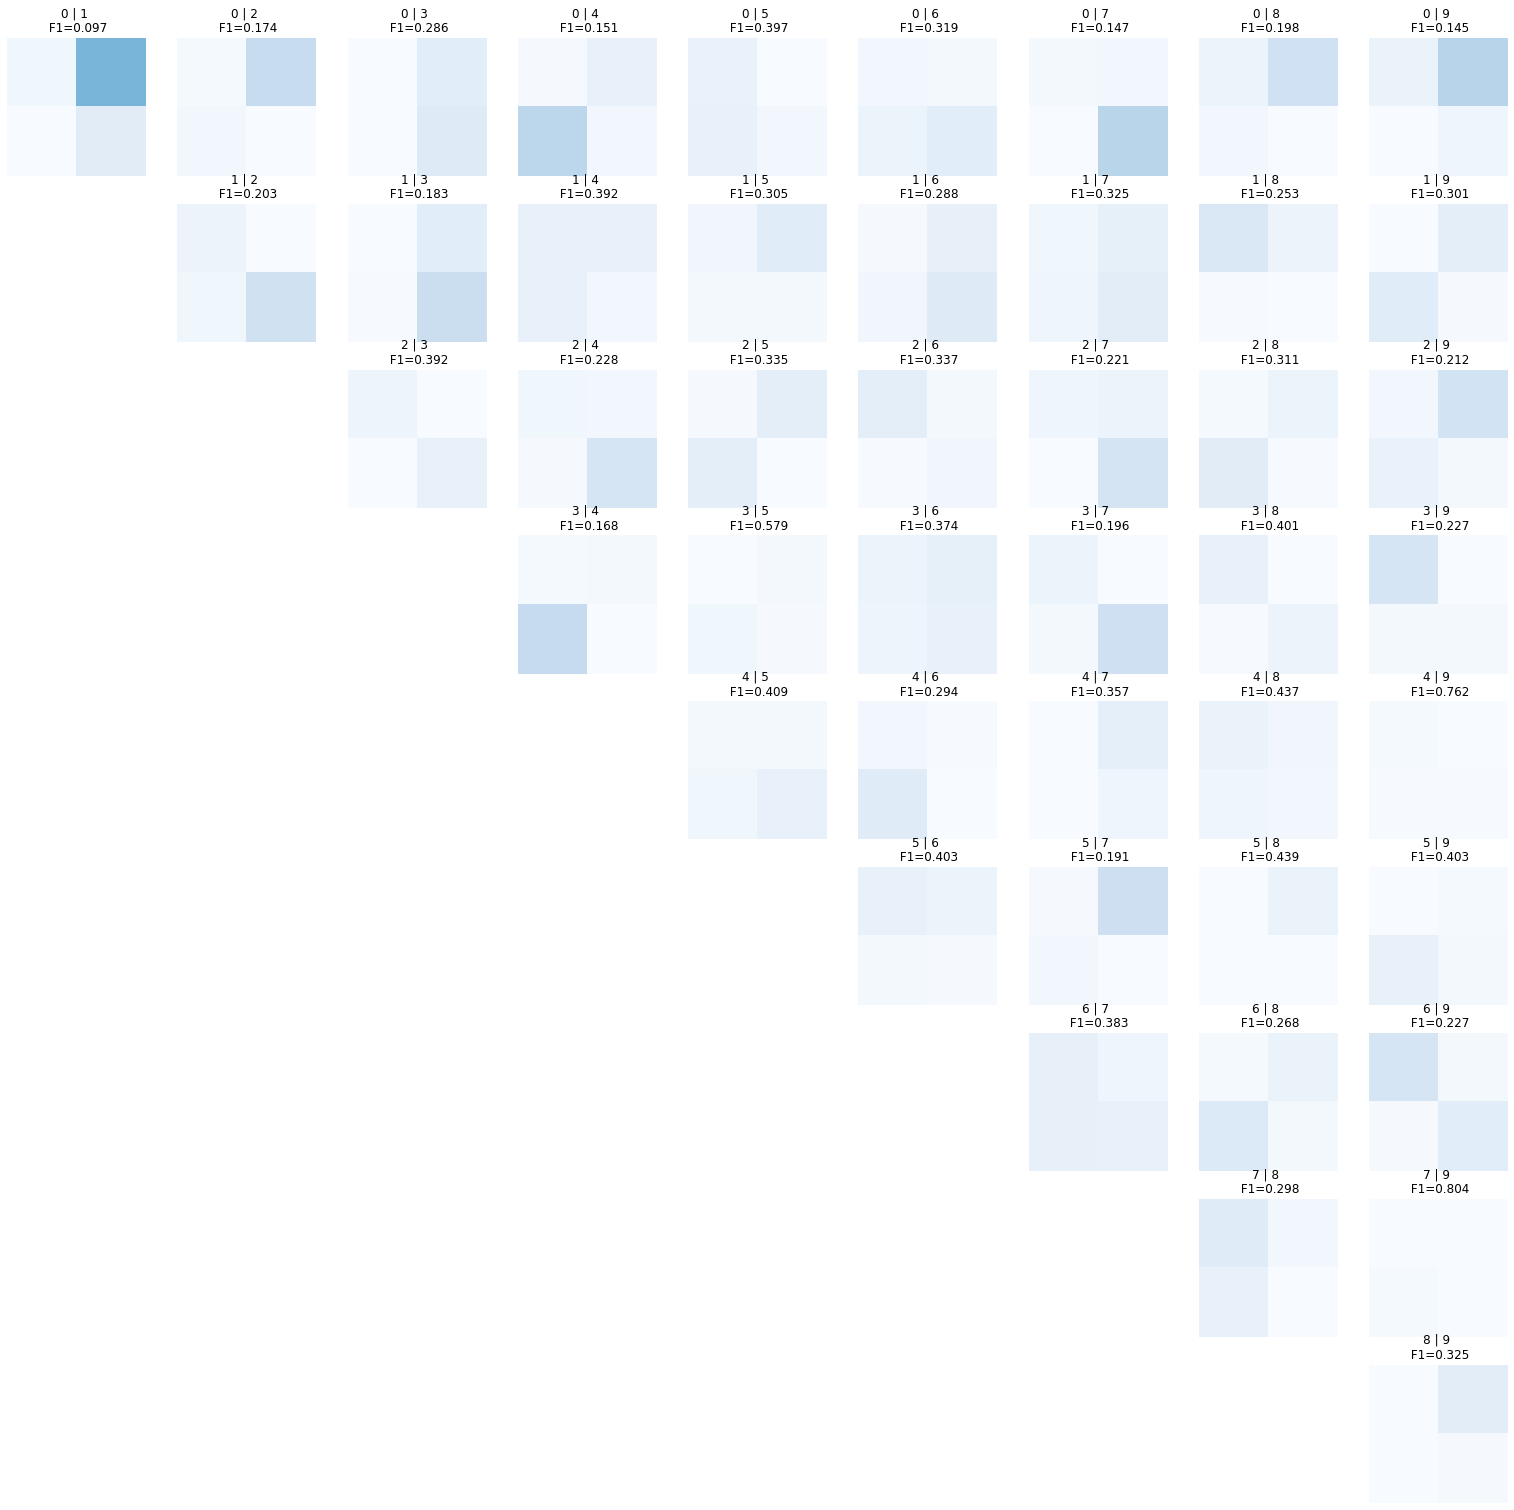

In [20]:
if os.path.exists("results/fischer_auto.json"):
    os.remove("results/fischer_auto.json")


fig,ax = plt.subplots(10,10,figsize=(30,30))

for subset in itertools.combinations([i for i in range(10)],2):
   
    x = all_numbers["x"][(all_numbers["y"] == subset[0]) | (all_numbers["y"] == subset[1])]
    y = all_numbers["y"][(all_numbers["y"] == subset[0]) | (all_numbers["y"] == subset[1])]

    autoencoder = Autoencoder(latent_dim)
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
    autoencoder.fit(x/255, x/255,
                epochs=2,batch_size=32,verbose=1)
    x_auto = autoencoder.encoder(x/255).numpy()
    del autoencoder
    tf.keras.backend.clear_session()

    x_auto = x_auto.reshape(x_auto.shape[0],2,2)

    fischer = cm.fischer_discriminat_ratio(x_auto, y)
    
    ax[subset[0],subset[1]].axis("off")
    ax[subset[0],subset[1]].set_title("{} | {} \n F1={:.3f}".format(subset[0],subset[1],(1/(1+np.amax(fischer)))))
    plot = ax[subset[0],subset[1]].imshow(np.round(fischer,5).reshape(2,2),cmap="Blues",vmin=0,vmax=20)


    h.log_results(filename="results/fischer_auto.json",result={
        str(subset):1/(1+np.amax(fischer))
    }) 

# hide combinations with empty plots
for i in range(10):
    for j in range(i+1):
        fig.delaxes(ax[i][j])

plt.show()